In [1]:
%matplotlib notebook
import numpy as np
from numpy import array, dot, sin, cos, pi, exp
from scipy.linalg import solve_banded
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
np.set_printoptions(
    precision=4, suppress=True)

<h1 align='center'>Методы решения начально-краевых задач <br>для гиперболических уравнений</h1>

## План

1. Постановка задачи
2. Точное решение методом Фурье
3. Сеточные методы
    - Идеи и основные понятия
    - Аппроксимация первых слоёв
        1. Двухслойная разностная схема
        2. Двухслойная разностная схема с применением самого уравнения
        3. Метод фиктивной точки
    - Аппроксимация уравнения с помощью разностных схем
        1. Явная трёхслойная схема
        2. Неявная трёхслойная схема

## Постановка задачи 

Рассмотриваем задачу о колебании струны с заданной динамикой на концах, а также с заданными начальным отклонением и скоростью:

$$ \frac{\partial^2 u}{\partial t^2} = a^2 \frac{\partial^2 u}{\partial x^2} + f(x, t),
   \text{ }x\in(0; l),\text{ }t > 0,\\ u\rvert_{t=0}=\varphi(x),\text{ }\frac{\partial u}{\partial t}\Big\rvert_{t=0}=\psi(x),\\
   u\rvert_{x=0}=\mu_1(t),\text{ }u\rvert_{x=l}=\mu_2(t).$$
   
В нашем случае задача имеет следующий вид (концы закреплены):

$$ \frac{\partial^2 u}{\partial t^2} = \frac{\partial^2 u}{\partial x^2} + 2 e^{-3t} \sin{\pi x},
   \text{ }x\in(0; 1),\text{ }t > 0,\\ u\rvert_{t=0}=-4 \sin{2\pi x}+2-3x,\text{ }\frac{\partial u}{\partial t}\Big\rvert_{t=0}=2\pi\sin{2\pi x},\\
   u\rvert_{x=0}=2,\text{ }u\rvert_{x=l}=-1.$$

In [2]:
a, l, T = 1, 1, 1
f   = lambda x, t: 2*exp(-3*t) * sin(pi*x)
phi = lambda x: -4*sin(2*pi*x) + 2 - 3*x
psi = lambda x: 2*pi*sin(2*pi*x)
mu1 = lambda t: 2
mu2 = lambda t: -1

## Точное решение методом Фурье 

In [3]:
def u_true(x, t):
    return (2 - 3*x +
            sin(2*pi*x) * (sin(2*pi*t) - 4*cos(2*pi*t)) +
            sin(pi*x)/(9+pi**2)*(-2*cos(pi*t)+6/pi*sin(pi*t)+2*exp(-3*t)))            

<IPython.core.display.Javascript object>


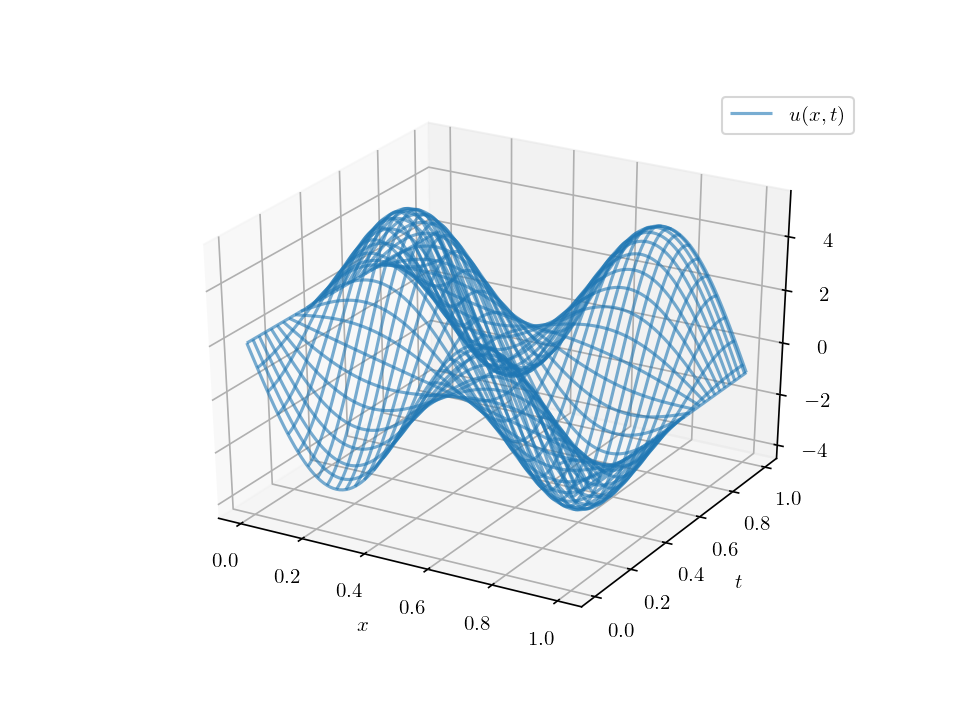

In [4]:
x_dense = np.linspace(0, l, 101)
t_dense = np.linspace(0, T, 101)
xx_dense, tt_dense = np.meshgrid(x_dense, t_dense)

fig0 = plt.figure()
ax1 = fig0.add_subplot(111, projection='3d')
ax1.plot_wireframe(xx_dense, tt_dense, u_true(xx_dense, tt_dense), alpha=0.6, label='$u(x, t)$')
ax1.set_xlabel('$x$'); ax1.set_ylabel('$t$')
ax1.legend();

In [5]:
def plot_solution(uu, xx, tt, u_true, method_name, ics_appr_name):
    global xx_dense, tt_dense
    h = xx[0, 1] - xx[0, 0]
    tau = tt[1, 0] - tt[0, 0]
    fig = plt.figure(figsize=(9, 4))
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.plot_wireframe(xx_dense, tt_dense, u_true(xx_dense, tt_dense), alpha=0.6, label='$u(x, t)$')
    ax1.plot_wireframe(xx, tt, uu, alpha=0.75, color='r',
                       label='$\hat{u}(x, t), h=%.2f, \\tau=%.2f$' % (h, tau))
    ax1.scatter(xx, tt, uu, alpha=0.75, s=10, c='r')
    ax1.set_title('%s method, %s for ics' % (method_name, ics_appr_name))
    
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot_wireframe(xx, tt, np.abs(uu - u_true(xx, tt)), 
                       label='$|\hat{u} - u|, h=%.2f, \\tau=%.2f$' % (h, tau))
    ax2.set_title('Error of solution')
    
    for ax in fig.get_axes():
        ax.set_xlabel('$x$'); ax.set_ylabel('$t$')
        ax.legend(loc=3);
        
    fig.tight_layout()
    return fig

## Сеточные методы 


Число Курранта $\gamma=\frac{a^2\tau^2}{h^2}$.

In [6]:
h, tau = 0.1, 0.05
gamma = a**2 * tau**2 / h**2
Nx, Nt = int(l/h), int(T/tau)
x = np.linspace(0, l, Nx+1)
t = np.linspace(0, T, Nt+1)
xx, tt = np.meshgrid(x, t)
ff = f(xx, tt)
uu = np.zeros_like(ff)
uu[:, 0] = mu1(t); uu[:, -1] = mu2(t)

### Аппроксимация первых слоёв 

Поскольку нам заданы два начальных условия, мы можем заполнить первые два временных слоя, которые будем использовать для "разгонки" разностной схемы. Более того, они нужны нам, чтобы была возможность аппроксимировать вторую производную функции по времени с помощью классической разностной схемы 2-го порядка. 

Нулевой слой ($t=0$), очевидно, точно заполняется исходя из условия для начального отклонения: 
$\forall i\in\{0, 1, ..., N_x\}\text{ }u_i^0=\varphi_i$. Более интересным является вопрос аппроксимации первого слоя с использованием условия для начальной скорости. Заметим, что нашей целью является выбор такого начального приближения, чтобы порядок аппроксимации был не меньше порядка аппроксимации самого ДУ на следующих слоях, чтобы не испортить качество работы метода.

In [7]:
uu[0] = phi(x)

#### 1-й способ: двухслойная разностная схема ($O(\tau)$) 

Воспользуемся двухслойной разностной схемой, довольно стандартной для аппроксимации первой производной:

$$ \frac{u_i^1-u_i^0}{\tau}=\frac{\partial u}{\partial t}\Big\rvert_i^0 + O(\tau),
\text{ }i\in\{1, ..., N_x-1\}.$$

Отбросив слагаемое $O(\tau)$, можем приближённо записать 

$$ u_i^1 = u_i^0 + \tau \frac{\partial u}{\partial t}\Big\rvert_i^0=\varphi_i+\tau\psi_i\text{ }i\in\{1, ..., N_x-1\}.$$

Способ нежелателен, если схема для аппроксимации уравнения имеет 2-й порядок относительно $\tau$.

In [8]:
# работает хорошо, пока psi(0)=psi(l)=0
u11 = phi(x) + tau*psi(x)

In [9]:
u11

array([ 2.    , -0.4665, -2.1054, -2.4054, -1.3665,  0.5   ,  2.3665,
        3.4054,  3.1054,  1.4665, -1.    ])

#### 2-й способ: двухслойная разностная схема с использованием самого уравнения ($O(\tau^2)$)

Воспользуемся всё тем же разностным шаблоном, только теперь разложим $u_i^1=u(x_i, \tau)$ по формуле Тейлора в окрестности точки $(x_i, 0)$ для каждого внутреннего узла 1-го слоя. Имеем:

$$\frac{u_i^1-u_i^0}{\tau}=
\frac{u_i^0+\tau\frac{\partial u}{\partial t}\Big\rvert_i^0+
\frac{\tau^2}{2}\frac{\partial^2u}{\partial t^2}\Big\rvert_i^0+O(\tau^3)-u_i^0}{\tau}=\\
=\frac{\partial u}{\partial t}\Big\rvert_i^0 + \frac{\tau}{2}\frac{\partial^2u}{\partial t^2}\Big\rvert_i^0 + O(\tau^2).$$

Но давайте взглянем на наше уравнение (а также на 1-е начальное условие):

$$\frac{\partial^2u}{\partial t^2}\Big\rvert_i=a^2\frac{\partial^2 u}{\partial x^2}\Big\rvert_i^0+f_i^0=a^2\varphi''_i+f_i^0.$$

Теперь, отбрасывая слагаемое $O(\tau^2)$, можем приближённо записать:

$$\frac{u_i^1-u_i^0}{\tau}=\psi_i+\frac{\tau}{2}(a^2\varphi''_i+f_i^0)\Rightarrow\\
  u_i^1 = \varphi_i + \tau\psi_i + \frac{\tau^2}{2}(a^2\varphi''_i + f_i^0),\text{ }i\in\{1, ..., N_x-1\}.$$
  
Этот способ уже, в отличие от предыдущего, даёт 2-й порядок аппроксимации по $\tau$ и позволяет без потери качества пользоваться соответствующими разностными схемами.

В нашем случае $\varphi''(x)=16\pi^2\sin{2\pi x}$.

In [10]:
# то же самое, работает хорошо, пока все участвующие функции обнуляются на концах отрезка
u12 = uu[0] + tau*psi(x) + tau**2/2 *(a**2 * 16*pi**2 * sin(2*pi*x) + ff[0])

In [11]:
u12

array([ 2.    , -0.3497, -1.9162, -2.2157, -1.2481,  0.5025,  2.2528,
        3.2197,  2.9192,  1.3512, -1.    ])

#### 3-й способ: метод фиктивной точки ($O(\tau^2)$)

Это ещё один способ, дающий второй по $\tau$ порядок аппроксимации для начальных условий. Теперь мы уже будем аппроксимировать производную $\frac{\partial u}{\partial t}\Big\rvert_0^i$ разностной схемой 2-го порядка. Для этого введём "фиктивный", $-1$-й слой $u_i^{-1}=u(x_i, -\tau)$. Запишем теперь 

$$ \frac{\partial u}{\partial t}\Big\rvert_i^0=\frac{u_i^1-u_i^{-1}}{2\tau}+O(\tau^2).$$

Опуская последнее слагаемое, приближённо можем записать $u_i^{-1}=u_i^1 - 2\tau\psi_i,\text{ }i\in\{1, ..., N_x-1\}$. 

А теперь приближённо запишем само дифференциальное уравнение во внутренних точках нулевого слоя, заменяя вторые производные разностными схемами второго порядка:

$$ \frac{u_i^1 - 2u_i^0 + u_i^{-1}}{\tau^2}=a^2\frac{u_{i+1}^0-2u_i^0+u_{i-1}^0}{h^2}+f_i^0,\text{ }i\in\{1, ..., N_x-1\}.$$

Вот сюда-то мы и подставим полученное выражение для $u_i^{-1}$. Получим

$$  \frac{2u_i^1 - 2u_i^0}{\tau^2}=a^2\frac{u_{i+1}^0-2u_i^0+u_{i-1}^0}{h^2}+f_i^0+\frac{2}{\tau}\psi_i,\text{ }i\in\{1, ..., N_x-1\},$$

откуда получаем выражение для $u_i^1$ со вторым и по $\tau$, и по $h$ порядком аппроксимации:

$$ u_i^1 = u_i^0 + \frac{a^2\tau^2}{2 h^2} (u_{i+1}^0-2u_i^0+u_{i-1}^0) + \frac{\tau^2}{2} f_i^0 + \tau \psi_i=\\
= \frac{\gamma}{2}\varphi_{i-1}+(1-\gamma)\varphi_i+\frac{\gamma}{2}\varphi_{i+1}+\frac{\tau^2}{2} f_i^0 +\tau\psi_i,
\text{ }i\in\{1, ..., N_x-1\}.$$

In [12]:
# тут безопасно
u13 = uu[0].copy()
u13[1:-1] = gamma/2*phi(x[:-2]) + (1-gamma)*phi(x[1:-1])+gamma/2*phi(x[2:])+tau**2/2*ff[0, 1:-1]+tau*psi(x[1:-1])

In [13]:
u13

array([ 2.    , -0.3535, -1.9223, -2.2218, -1.2518,  0.5025,  2.2566,
        3.2258,  2.9253,  1.355 , -1.    ])

### Аппроксимация уравнения на старших слоях

#### A. Явная трёхслойная схема

Шаблон:

Аппроксимация производных разностными схемами во внутренних точках слоя $k$-го слоя сетки ($i\in\{1, ..., N_x-1\}$):

$$ \frac{\partial^2 u}{\partial t^2}\Big\rvert_i^k = \frac{u_i^{k+1}-2u_i^k+u_i^{k-1}}{\tau^2} + O(\tau^2),\\
   \frac{\partial^2 u}{\partial x^2}\Big\rvert_i^k = \frac{u_{i+1}^k-2u_i^k+u_{i-1}^k}{h^2} + O(h^2).$$
   
Подставим разностные аналоги в уравнение, которое после этого в явном виде разрешается относительно $u_i^{k+1}$, что даёт нам следующую схему для определения значений на $k+1$-м слое, дающую порядок аппроксимации $O(h^2+\tau^2)$.

$$ u_i^{k+1}=2u_i^k-u_i^{k-1}+\gamma(u_{i-1}^k-2u_i^k+u_{i+1}^k)+\tau^2 f_i^k,\text{ }i\in\{1, ..., N_x-1\}.$$

С её помощью поочерёдно заполняем значения на всех временных слоях.

In [14]:
uu_expl1 = uu.copy()
uu_expl1[1] = u11 # вот не знаю, делать индекс [1, 1:-1], и u11 длины Nx-1, или оставить всё как есть
uu_expl2 = uu.copy()
uu_expl2[1] = u12
uu_expl3 = uu.copy()
uu_expl3[1] = u13

for k in range(1, Nt):
    for uu_e in [uu_expl1, uu_expl2, uu_expl3]:
        uu_e[k+1, 1:-1] = (2*(1-gamma)*uu_e[k, 1:-1] - uu_e[k-1, 1:-1] +
                           gamma*(uu_e[k, :-2] + uu_e[k, 2:]) + tau**2 * ff[k, 1:-1])

<IPython.core.display.Javascript object>


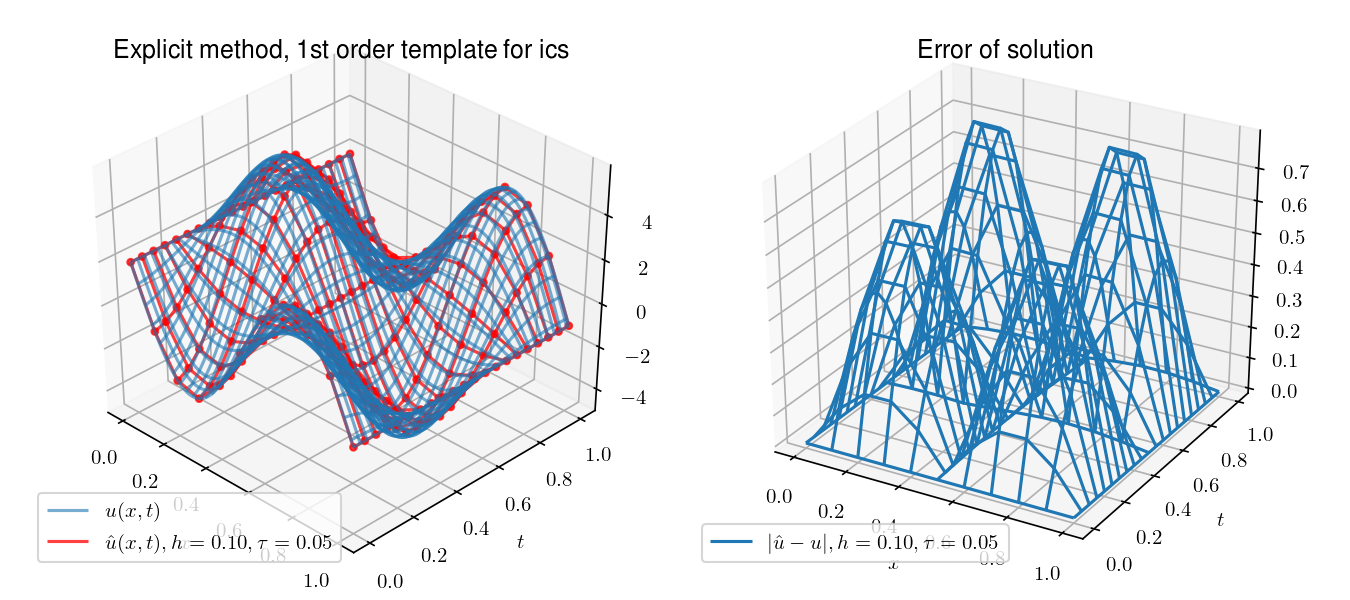

In [15]:
fig1 = plot_solution(uu_expl1, xx, tt, u_true, 'Explicit', '1st order template')

<IPython.core.display.Javascript object>


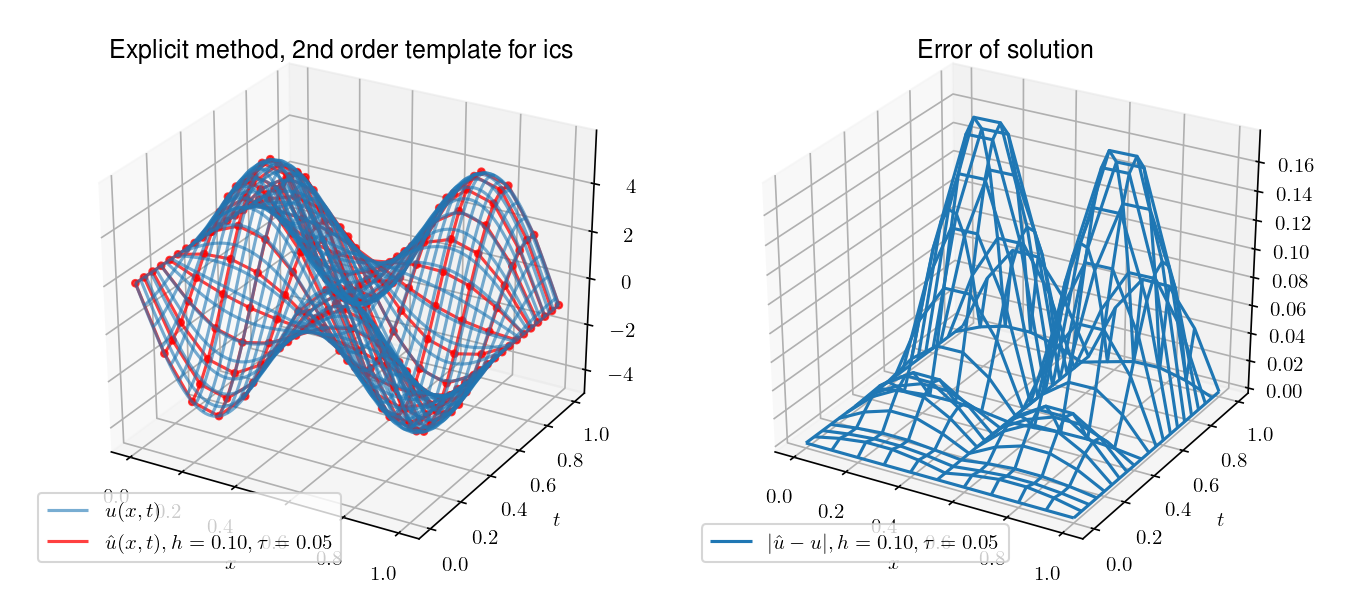

In [16]:
fig2 = plot_solution(uu_expl2, xx, tt, u_true, 'Explicit', '2nd order template')

<IPython.core.display.Javascript object>


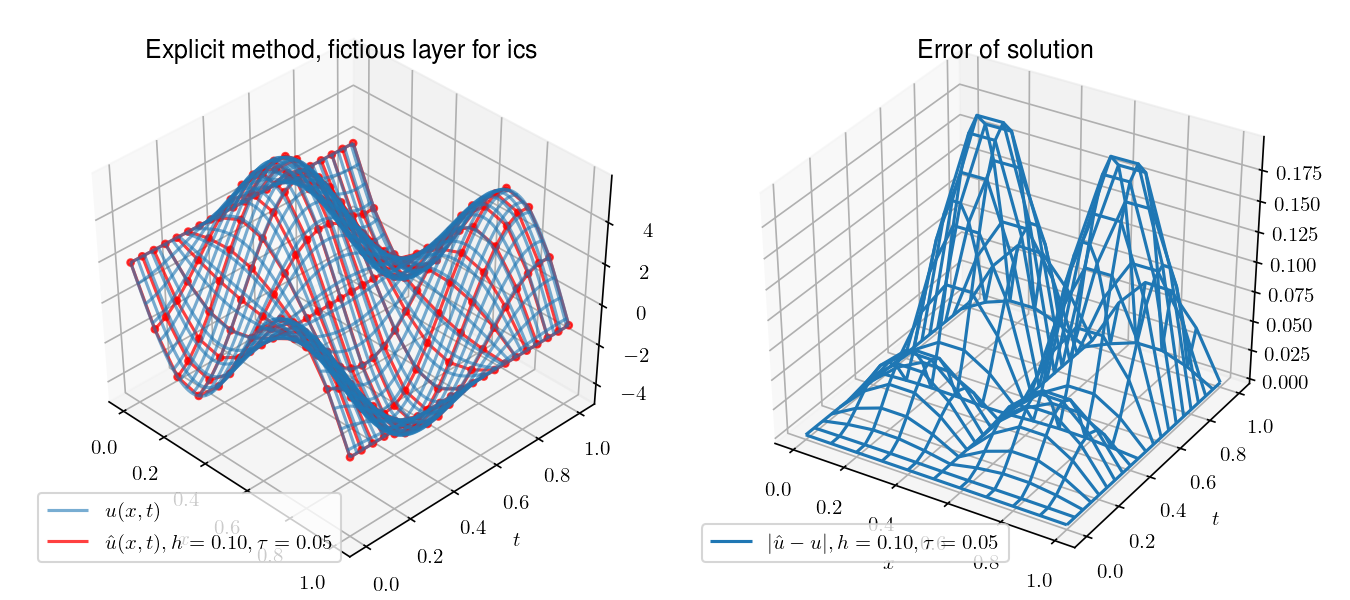

In [17]:
fig3 = plot_solution(uu_expl3, xx, tt, u_true, 'Explicit', 'fictious layer')

#### В. Неявная трёхслойная схема 

In [ ]:
uu_impl1 = uu.copy()
uu_impl1[1] = u11
uu_impl2 = uu.copy()
uu_impl2[1] = u12
uu_impl3 = uu.copy()
uu_impl3[1] = u13